In [1]:
from math import exp

from sympy.stats import E, variance, Die, Normal, Binomial
from sympy.stats import P as Prob

import matplotlib.pyplot as plt

### terminology

* 'negative' ~ $y=0$
* 'positive' ~ $y=1$
* 'natural' ~ a sample from $X=X_1 + Lap\left(0, \frac{\Delta f}{\epsilon_\text{true}}\right)$
* 'alternative' ~ a special value defined as $\bot=X_1-1000(\frac{\Delta f}{\epsilon_\text{true}}, \frac{\Delta f}{\epsilon_\text{true}}, \frac{\Delta f}{\epsilon_\text{true}})$

In [2]:
from empirical_privacy.laplace_mechanism import EvaluateKNNLaplaceStatDist
from empirical_privacy.laplace_mechanism import FitKNNModelLaplace

from math import sqrt

import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets


cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_knn(dataset_settings, training_set_size, test_set_size,
             plot_alternative_samples=True, random_seed='hats'):
    scale = eps/ds['epsilon']

    knn = FitKNNModelLaplace(dataset_settings=dataset_settings,
                            samples_per_class=int(round(training_set_size / 2)),
                            random_seed='hats',
                            in_memory=True)
    knn.requires()
    knn.run()

    X = np.vstack((knn.reqs_['samples_positive']['X'],
                   knn.reqs_['samples_negative']['X']))
    y = np.concatenate((knn.reqs_['samples_positive']['y'].ravel(),
                   knn.reqs_['samples_negative']['y'].ravel()))
    if not plot_alternative_samples:
        I = X[:,1] <= -1000 * scale
        X = X[~I,:]
        y = y[~I]
        print('not plotting {} alternative samples'.format(np.argwhere(I).size))
    
    plot_decision(knn.output_['KNN'], X, y)

def plot_decision(clf, X, y, num=5000):
    plt.figure(figsize=(10,10))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xs = np.linspace(x_min, x_max, num=int(sqrt(num)))
    ys = np.linspace(y_min, y_max, num=int(sqrt(num)))
    xx, yy= np.meshgrid(xs, ys, )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(yy.ravel())])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold ,s=20)
    


### Experiment Settings

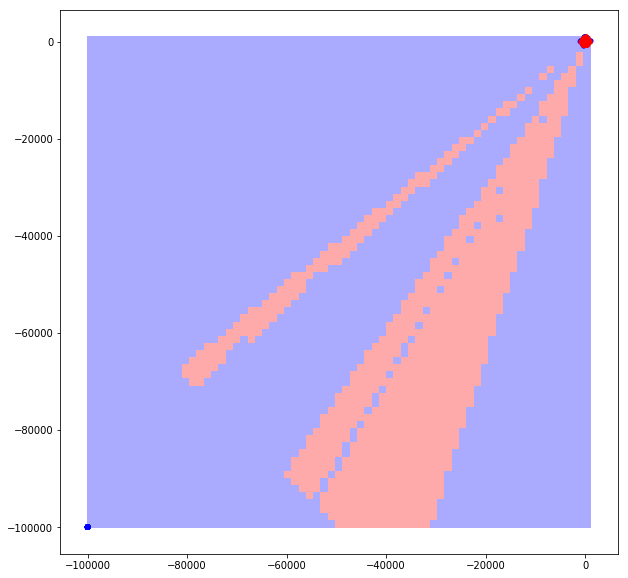

In [5]:
eps = 0.01
claimed_eps = eps * 0.9

ds = {
        'database_0' : (0, 0, 0),
        'database_1' : (1, 0, 0),
        'sensitivity': 1.,
        'epsilon'    : eps,
        'claimed_epsilon': claimed_eps,
        'delta'      : 0.
}

CLAIMED_EPS = 0.01
probability_of_natural_sample = 1 / (exp(CLAIMED_EPS))
probability_of_alternative_sample = 1 - probability_of_natural_sample

training_set_size = int(2**14)
test_set_size = int(2**10)
prior_positive = 0.5
prior_negative = 1 - prior_positive  #

plot_knn(ds, training_set_size, test_set_size, plot_alternative_samples=True)

## sympy

In [46]:
vars_ = [n_natural_negative, n_natural_positive, n_alternative]
P = 1.0
for v in vars_:
    P*=Prob(v(test_set_size) >=1)
    P*=Prob(v(training_set_size) >= 1)
    
print(P)

0.987930624264561


In [35]:
def n_natural_negative(n):
    return Binomial('n_natural_negative',
                              n=n,
                              p=prior_negative
                         )
def n_natural_positive(n):
    return Binomial('n_natural_positive',
                             n=n,
                             p=prior_positive*probability_of_natural_sample)
def n_alternative(n):
    return Binomial('n_alternative',
                        n=n,
                        p=prior_positive*probability_of_alternative_sample)

